In [44]:
import requests
import json

from census import Census
from us import states

from config import apikey
from config import gkey

import gmaps
gmaps.configure(api_key=gkey)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#API calls census using wrapper
c = Census(apikey, year=2017)
census_data = c.acs5.get(("B01003_001E","B01002_001E"),{'for': 'county:*', 'in': 'state:*' })

#converting to dataFrame
census_pd = pd.DataFrame(census_data)

#Renaming the columns
census_pd=census_pd.rename(columns={"B01003_001E":"Total Population","B01002_001E":"Median Age","state":"fips"})
census_pd.head()


,Total Population,Median Age,fips,county
0,34933.0,38.1,72,047
1,11297.0,43.5,72,095
2,21661.0,36.4,72,111
3,148863.0,39.5,72,113
4,38970.0,42.0,72,131


In [26]:
#extracting state population from census data

Population=census_pd.groupby('fips')['Total Population'].sum()
final_fips=census_pd.groupby('fips')['fips'].first()

state_population=pd.DataFrame({"Total Population":Population,"State Fips":final_fips})
state_population.loc[:,'State Fips']=state_population["State Fips"].astype('int64')

state_population.head()

,Total Population,State Fips
fips,,
01,4850771.0,1
02,738565.0,2
04,6809946.0,4
05,2977944.0,5
06,38982847.0,6


In [25]:
zip_path="state_fips_master.csv"
zip_df=pd.read_csv(zip_path)
zip_df=zip_df.rename(columns={"fips":"State Fips"})

In [5]:
#Merging the census_pd with state_zip_df to obtain state_name column in Census dataFrame

Census_df=pd.merge(state_population,zip_df,on="State Fips")
Census_df=Census_df.rename(columns={"State Fips":"fips","state_name":"State Name"})
Census_df.head()

,Total Population,fips,State Name,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
0,4850771.0,1,Alabama,AL,Alabama AL,40,3,6,1,South,East South Central
1,738565.0,2,Alaska,AK,Alaska AK,40,4,9,2,West,Pacific
2,6809946.0,4,Arizona,AZ,Arizona AZ,40,4,8,4,West,Mountain
3,2977944.0,5,Arkansas,AR,Arkansas AR,40,3,7,5,South,West South Central
4,38982847.0,6,California,CA,California CA,40,4,9,6,West,Pacific


In [6]:
csv_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the CSV into a Pandas DataFrame
covid_df = pd.read_csv(csv_path)

# Print the first five rows of data to the screen
covid_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [90]:
group=covid_df.groupby('state')
first_date=group['date'].first()
Cases_start=group['cases'].sum()

New_df=pd.DataFrame({"Date":first_date,"Cases Count @Start":Cases_start})
New_df=New_df.reset_index()
New_df


,state,Date,Cases Count @Start
0,Alabama,2020-03-13,29326
1,Alaska,2020-03-12,3008
2,Arizona,2020-01-26,33227
3,Arkansas,2020-03-11,14700
4,California,2020-01-25,235247
5,Colorado,2020-03-05,75296
6,Connecticut,2020-03-08,93153
7,Delaware,2020-03-11,11205
8,District of Columbia,2020-03-07,15923
9,Florida,2020-03-01,184313


In [61]:
#Covid-19 Data on County level

#extracting latest information from the live data
cases_covid=covid_df.groupby(['fips','county','state'])['cases'].last()
deaths_covid=covid_df.groupby(['fips','county','state'])['deaths'].last()
date_covid=covid_df.groupby(['fips','county','state'])['date'].last()
fips_covid=covid_df.groupby(['fips','county','state'])['fips'].first()
state_covid=covid_df.groupby(['fips','county','state'])['state'].first()
county_covid=covid_df.groupby(['fips','county','state'])['county'].first()

#creating new dataframe
County_Covid_df=pd.DataFrame({"Date":date_covid,
                             "County":county_covid,
                             "Total Number of Covid-19 Cases":cases_covid,
                             "Death due to Covid-19":deaths_covid})
County_Covid_df.head()

,,,Date,County,Total Number of Covid-19 Cases,Death due to Covid-19
fips,county,state,,,,
1001.0,Autauga,Alabama,2020-03-24,Autauga,1,0
1003.0,Baldwin,Alabama,2020-03-14,Baldwin,1,0
1005.0,Barbour,Alabama,2020-04-03,Barbour,1,0
1007.0,Bibb,Alabama,2020-03-30,Bibb,2,0
1009.0,Blount,Alabama,2020-03-25,Blount,1,0


In [23]:
#Covid-19 Data on State Level

cases_state=covid_df.groupby(['state'])['cases'].sum()
deaths_state=covid_df.groupby(['state'])['deaths'].sum()
date_state=covid_df.groupby(['state'])['date'].last()
state_name=covid_df.groupby(['state'])['state'].last()

State_Covid_df=pd.DataFrame({"Date":date_state,"State Name":state_name,"Total Covid-19 Cases":cases_state,"Total Deaths Covid-19":deaths_state})

In [22]:
#Merging Total population per state with covid parameters
complete_df=pd.merge(State_Covid_df,Census_df,on='State Name')
complete_df=complete_df[["Date","State Name","Total Covid-19 Cases","Total Deaths Covid-19","Total Population","fips"]]

In [21]:
#Adding Latitude and Longitude for HeatMap
latlng_path="statelatlong.csv"
latlng_df=pd.read_csv(latlng_path)
latlng_df=latlng_df.rename(columns={"City":"State Name"})
HeatMap_df=pd.merge(latlng_df,complete_df,on="State Name")

In [67]:
#state mortality rates

mortality_df=(HeatMap_df['Total Deaths Covid-19']/HeatMap_df['Total Population'])*100000
HeatMap_df['Mortality per 100,000']=mortality_df
HeatMap_df.head()

,State,Latitude,Longitude,State Name,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips,"Mortality per 100,000"
0,AL,32.601011,-86.680736,Alabama,2020-04-11,29326,664,4850771.0,1,13.688546
1,AK,61.302501,-158.775020,Alaska,2020-04-11,3008,54,738565.0,2,7.311476
2,AZ,34.168219,-111.930907,Arizona,2020-04-11,33227,817,6809946.0,4,11.997158
3,AR,34.751928,-92.131378,Arkansas,2020-04-11,14700,241,2977944.0,5,8.092832
4,CA,37.271875,-119.270415,California,2020-04-11,235247,5639,38982847.0,6,14.465337


In [30]:
#Covid 'Mortality per 100,000' per state in the USA

locations = HeatMap_df[["Latitude", "Longitude"]]

# Plot Heatmap
Covid = gmaps.figure()

impact=HeatMap_df['Mortality per 100,000']

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=impact,dissipating=False, max_intensity=10,point_radius=1)

# Add layer
Covid.add_layer(heat_layer)

# Display figure
Covid

Figure(layout=FigureLayout(height='420px'))

# Calculating R-naught Value

#R-naught-he basic reproduction number of an infection can be thought of as the expected number of cases directly generated by one case in a population where all individuals are susceptible to infection

#Formula-
EXP((LN(Population/((1/(case[current]/(case[start]*Population)))-1)))/(current-start))
where,
a. LN is the natural logarithm;
b. case[start] is the case count on starting day;
c. case[current] be the case count on current
d. Population is the population of the state
e. current = no. of days from the start of the outbreak and start = 0

In [119]:
#df=covid_df.copy()

In [144]:
case_current=HeatMap_df['Total Covid-19 Cases']
population=HeatMap_df['Total Population']
case_start=New_df['Cases Count @Start']
current=pd.to_datetime(HeatMap_df['Date'])-pd.to_datetime(New_df['Date'])
current=current.dt.days

In [147]:
#Calculating r_o in loop
states = []
R0 = []

for i in range(1,50):
    r_o=np.exp(np.log(population[i]/(1/case_current[i])/(case_start[i]*population[i]))-1/(current[i]-start))
    R0.append(r_o)
    states.append(list(HeatMap_df['State Name'])[i])
    i=i+1

R_df= pd.DataFrame({"State Name":states,"R-naught":R0})

covid_stat_df=pd.merge(R_df,complete_df, on="State Name")
covid_stat_df.head()

,State Name,R-naught,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips
0,Alaska,0.967216,2020-04-11,3008,54,738565.0,2
1,Arizona,0.986928,2020-04-11,33227,817,6809946.0,4
2,Arkansas,0.968257,2020-04-11,14700,241,2977944.0,5
3,California,0.987097,2020-04-11,235247,5639,38982847.0,6
4,Colorado,0.973335,2020-04-11,75296,2166,5436519.0,8


In [159]:
import geopandas as gpd
shapefile='data/cb_2018_us_state_500k.shp'
gdf = gpd.read_file(shapefile)[['NAME','geometry']]
gdf.columns=['State Name','geometry']
gdf.head()

,State Name,geometry
0,Mississippi,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,North Carolina,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,Oklahoma,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,Virginia,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,West Virginia,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [148]:
#Merging geodataframe and dataframe 
Ro_Visual = gdf.merge(covid_stat_df, left_on = 'State Name', right_on = 'State Name')

In [160]:
Ro_Visual

,State Name,geometry,R-naught,Date,Total Covid-19 Cases,Total Deaths Covid-19,Total Population,fips
0,Mississippi,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",0.109550,2020-04-11,25532,671,2986220.0,28
1,North Carolina,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",3.918159,2020-04-11,40543,541,10052564.0,37
2,Oklahoma,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",5.341825,2020-04-11,17737,748,3896251.0,40
3,Virginia,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",0.734407,2020-04-11,40715,831,8365952.0,51
4,West Virginia,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",0.208810,2020-04-11,5020,41,1836843.0,54
5,Louisiana,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",15.148671,2020-04-11,186024,6996,4663461.0,22
6,Michigan,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",3.830663,2020-04-11,225892,9639,9925568.0,26
7,Massachusetts,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ...",25.009500,2020-04-11,194472,4093,6789319.0,25
8,Idaho,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",3.347998,2020-04-11,14884,205,1657375.0,16
9,Florida,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",11.249226,2020-04-11,184313,3419,20278447.0,12


In [168]:
Ro_Visual.drop(labels=24,axis=0,inplace=True)
Ro_Visual

KeyError: '[24] not found in axis'

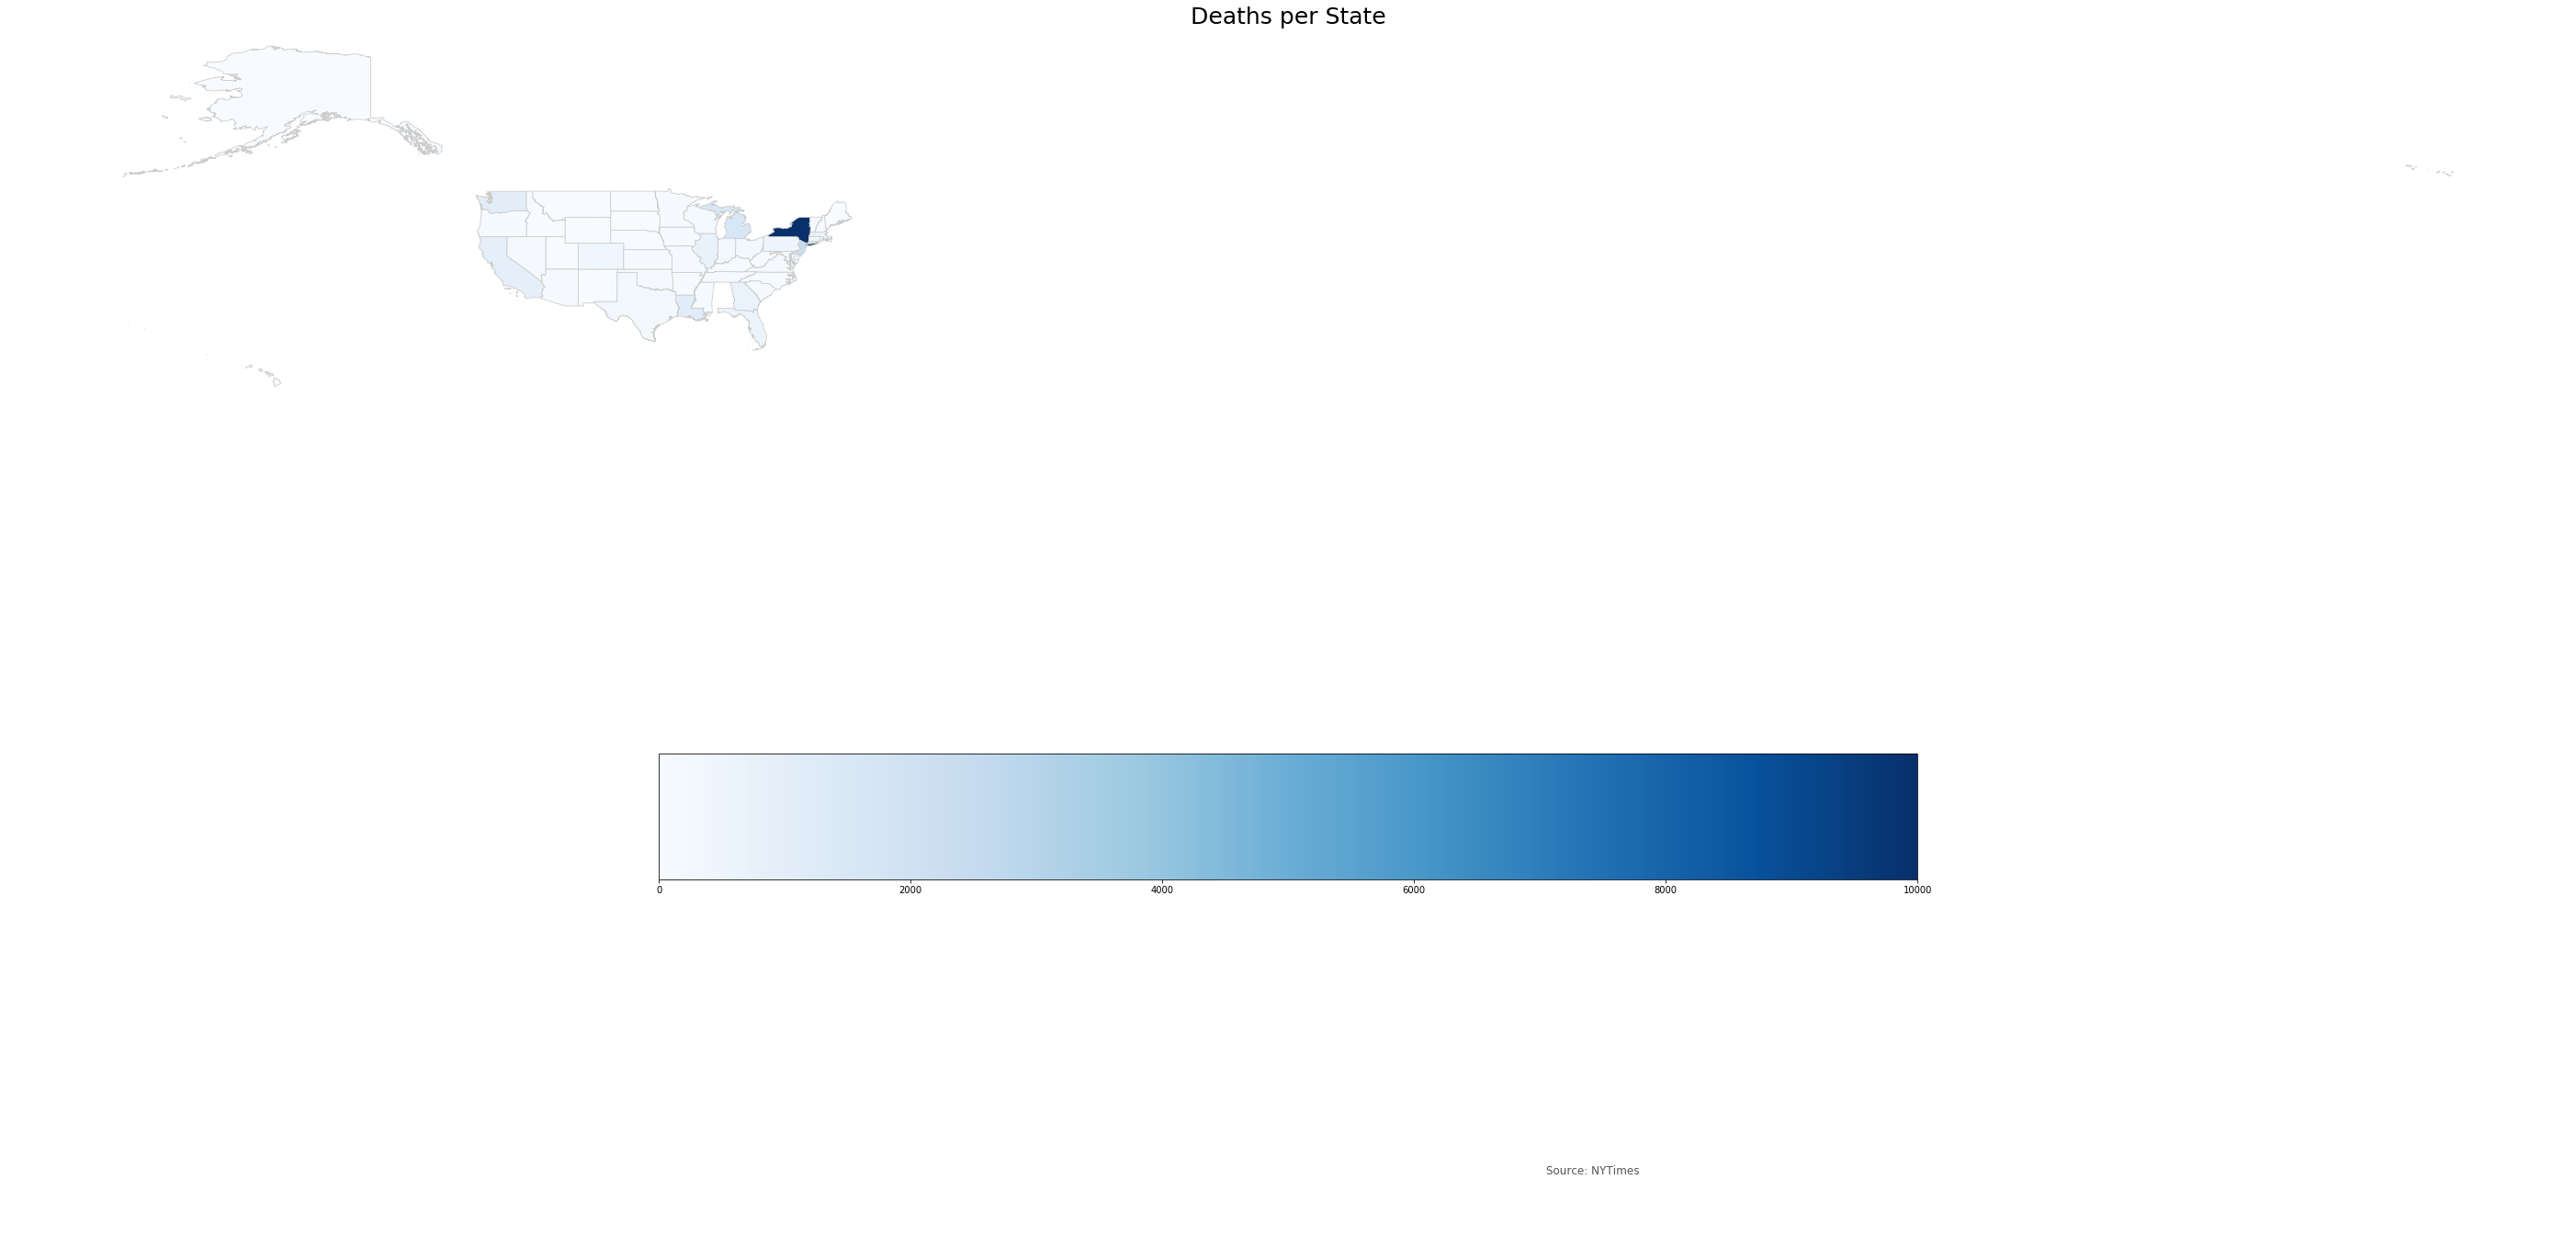

In [161]:
#value to be visualised

variable='Total Deaths Covid-19'

# set the range for the choropleth values
vmin, vmax = 0, 10000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(50, 70))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('Deaths per State', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: NYTimes', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

# create map
Ro_Visual.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
            
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 10)